In [47]:
!pip install datashader


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [48]:
# Import basic required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')
sns.set_style({'axes.grid':False})

# Advanced visualization modules(datashader)
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import viridis, inferno

# 1. Data Loading and Basic Processing

In [49]:
train = pd.read_csv('/data/notebook_files/NYC_train_cleaned.csv')
test = pd.read_csv('/data/notebook_files/NYC_test_cleaned.csv')
train.columns, test.columns, train.shape, test.shape

(Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
       dtype='object'),
 Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
       dtype='object'),
 (800000, 7),
 (200000, 7))

In [50]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], infer_datetime_format=True)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], infer_datetime_format=True)

In [51]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,22.5,2013-05-30 23:51:00+00:00,-73.99959,40.714508,-73.914310,40.685000,4
1,8.5,2012-09-23 10:42:49+00:00,-73.99823,40.760864,-73.989150,40.743465,1
2,14.1,2011-04-13 10:08:00+00:00,-73.99050,40.759070,-73.987946,40.761450,2
3,10.1,2012-06-05 14:44:27+00:00,-73.98430,40.761910,-73.973080,40.748734,1
4,4.1,2009-12-17 13:20:00+00:00,-73.94736,40.776060,-73.955940,40.779636,5


In [52]:
import warnings
warnings.filterwarnings('ignore')

# 2. Data exploration

## 2.1 Fare Amount (Output variable)

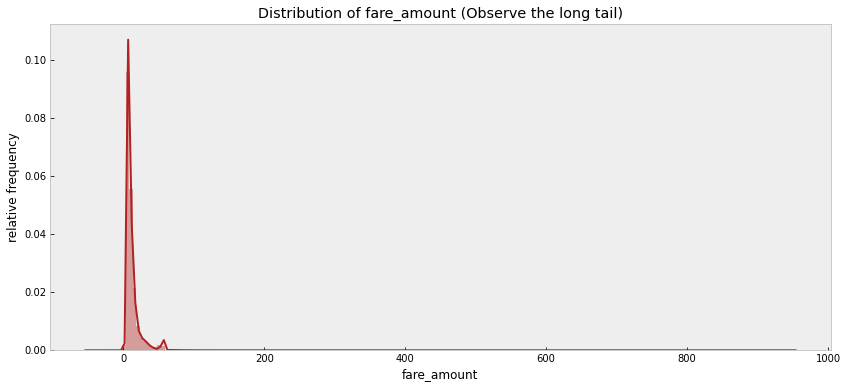

In [53]:
fig, ax = plt.subplots(figsize = (14,6))
sns.distplot(train.fare_amount, bins = 200, color = 'firebrick', ax = ax)
ax.set_title('Distribution of fare_amount (Observe the long tail)')
ax.set_ylabel('relative frequency')
plt.show()

## 2.2 Passenger Count

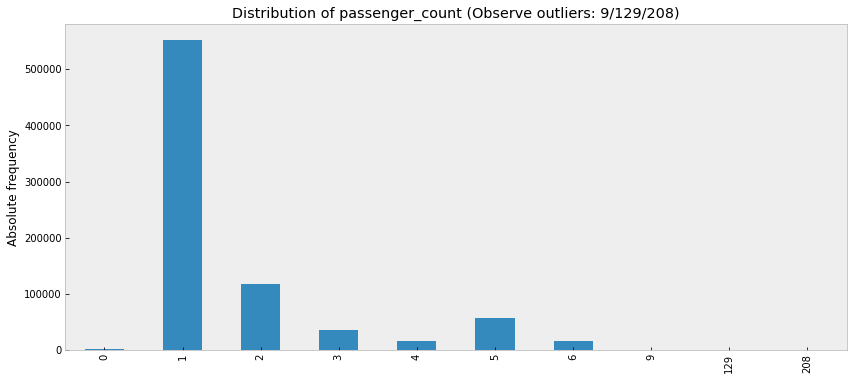

In [54]:
fig, ax = plt.subplots(figsize = (14,6))
class_dist = train.passenger_count.value_counts()
class_dist = class_dist.sort_index()
class_dist.plot(kind = 'bar', ax = ax)
ax.set_title('Distribution of passenger_count (Observe outliers: 9/129/208)')
ax.set_ylabel('Absolute frequency')
plt.show()

# 3. Data cleaning - removing outliers

### 3.1 Removing outliers w.r.t. fare amount

In [55]:
# Drop fare_amount less than 0.
neg_fare = train.loc[train.fare_amount<0, :].index
train.drop(neg_fare, axis = 0, inplace = True)

# Drop rows greater than 100 and lesser than 2.5
fares_to_drop = train.loc[(train.fare_amount>100) | (train.fare_amount<2.5), :].index
train.drop(fares_to_drop, axis = 0, inplace = True)
print('Shape of training data after dropping outliers: {}'.format(train.shape))

# Do the same for the test data
neg_fare = test.loc[test.fare_amount<0, :].index
test.drop(neg_fare, axis = 0, inplace = True)
fares_to_drop = test.loc[(test.fare_amount>100) | (test.fare_amount<2.5), :].index
test.drop(fares_to_drop, axis = 0, inplace = True)

Shape of training data after dropping outliers: (799636, 7)


## 3.2 Removing outliers w.r.t. latitudes and longitudes
Check the 2.5 and 97.5 percentiles of both

In [56]:
def percentile(variable):
    two_and_half = variable.quantile(0.25)
    ninty_seven_half = variable.quantile(0.975)
    print('2.5 and 97.5 percentile of {} is respectively: {:0.2f}, and {:0.2f}'.format(variable.name, two_and_half, ninty_seven_half))

percentile(train.pickup_latitude)
percentile(train.dropoff_latitude)
percentile(train.pickup_longitude)
percentile(train.dropoff_longitude)

2.5 and 97.5 percentile of pickup_latitude is respectively: 40.73, and 40.80
2.5 and 97.5 percentile of dropoff_latitude is respectively: 40.73, and 40.81
2.5 and 97.5 percentile of pickup_longitude is respectively: -73.99, and -73.78
2.5 and 97.5 percentile of dropoff_longitude is respectively: -73.99, and -73.79


In [57]:
train = train.loc[train.pickup_latitude.between(left = 40, right = 42), :]
train = train.loc[train.dropoff_latitude.between(left = 40, right = 42), :]

train = train.loc[train.pickup_longitude.between(left = -75, right = -72), :]
train = train.loc[train.dropoff_longitude.between(left = -75, right = -72), :]
print('Shape of training data after after dropping outliers from lats and lons: {}'.format(train.shape))

test = test.loc[test.pickup_latitude.between(left = 40, right = 42), :]
test = test.loc[test.dropoff_latitude.between(left = 40, right = 42), :]
test = test.loc[test.pickup_longitude.between(left = -75, right = -72), :]
test = test.loc[test.dropoff_longitude.between(left = -75, right = -72), :]

Shape of training data after after dropping outliers from lats and lons: (783063, 7)


### 3.3 Removing outliers w.r.t. passenger count

In [58]:
passenger_count_to_drop = train.loc[(train.passenger_count > 6)].index
train.drop(passenger_count_to_drop, axis = 0, inplace = True)
print('Shape of training data after dropping outliers w.r.t. passenger_count:{}'.format(train.shape))

passenger_count_to_drop = test.loc[(test.passenger_count > 6)].index
test.drop(passenger_count_to_drop, axis = 0, inplace = True)

display(train.passenger_count.describe())

Shape of training data after dropping outliers w.r.t. passenger_count:(783061, 7)


count    783061.000000
mean          1.686926
std           1.309967
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

# 4. Feature Engineering

In [59]:
merged = pd.concat([train,test], axis = 0, sort=False)

## 4.1 Great circle distance using haversine formula

In [60]:
def great_circle_distance(lon1,lat1,lon2,lat2):
    R = 6371000 # Approximate mean radius of earth (in m)

    # Convert decimal degrees to ridians
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Distance of lons and lats in radians
    dis_lon = lon2 - lon1
    dis_lat = lat2 - lat1

    # Haversine implementation
    a = np.sin(dis_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dis_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dis_m = R*c # Distance in meters
    dis_km = dis_m/1000 # Distance in km
    return dis_km

merged['great_circle_distance'] = great_circle_distance(merged.pickup_longitude, merged.pickup_latitude, merged.dropoff_longitude, merged.dropoff_latitude)

## 4.2 Euclidean distance

In [61]:
# Convert lons and lats into cartesian coordinates. Assume the earth as sphere not ellipsoid
R = 6371000 # Approximate mean radius of earth (in m)
# lons and lats must be in radians
lon1,lat1,lon2,lat2 = map(np.radians, [merged.pickup_longitude, merged.pickup_latitude, merged.dropoff_longitude, merged.dropoff_latitude])
merged['pickup_x'] = R*np.cos(lon1)*np.cos(lat1)
merged['pickup_y'] = R*np.sin(lon1)*np.cos(lat1)
merged['dropoff_x'] = R*np.cos(lon2)*np.cos(lat2)
merged['dropoff_y'] = R*np.sin(lon2)*np.cos(lat2)

# Now calculate the euclidean distance
x1 = merged['pickup_x']
y1 = merged['pickup_y']
x2 = merged['dropoff_x']
y2 = merged['dropoff_y']
merged['euclidean_distance'] = (np.sqrt(( x1 - x2)**2 + ( y1 - y2)**2))/1000 # in km

## 4.3 Manhattan distance

In [62]:
merged['manhattan_distance'] = (np.abs(x1 - x2) + np.abs(y1 - y2))/1000 # in km

## 4.4 Find pickup hour/day/date/month/year 

In [63]:
merged['pickup_hour'] = merged.pickup_datetime.dt.hour
merged['pickup_date'] =  merged.pickup_datetime.dt.day
merged['pickup_day_of_week'] =  merged.pickup_datetime.dt.dayofweek
merged['pickup_month'] =  merged.pickup_datetime.dt.month
merged['pickup_year'] =  merged.pickup_datetime.dt.year

In [64]:
merged.drop(['pickup_datetime'], axis = 1, inplace = True)

## 4.5 Alignment

In [65]:
train_df = merged.iloc[:train.shape[0], :]
test_df = merged.iloc[train.shape[0]:, :]

In [66]:
train_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,great_circle_distance,pickup_x,pickup_y,dropoff_x,dropoff_y,euclidean_distance,manhattan_distance,pickup_hour,pickup_date,pickup_day_of_week,pickup_month,pickup_year
0,22.5,-73.99959,40.714508,-73.914310,40.685000,4,7.902551,1.331092e+06,-4.641944e+06,1.338593e+06,-4.642014e+06,7.500826,7.569989,23,30,3,5,2013
1,8.5,-73.99823,40.760864,-73.989150,40.743465,1,2.080381,1.330275e+06,-4.638679e+06,1.331358e+06,-4.639682e+06,1.476484,2.086517,10,23,6,9,2012
2,14.1,-73.99050,40.759070,-73.987946,40.761450,2,0.341040,1.330937e+06,-4.638625e+06,1.331096e+06,-4.638399e+06,0.275910,0.384521,10,13,2,4,2011
3,10.1,-73.98430,40.761910,-73.973080,40.748734,1,1.743469,1.331382e+06,-4.638282e+06,1.332554e+06,-4.638941e+06,1.344610,1.830820,14,5,1,6,2012
4,4.1,-73.94736,40.776060,-73.955940,40.779636,5,0.824653,1.334088e+06,-4.636436e+06,1.333322e+06,-4.636386e+06,0.767715,0.815957,13,17,3,12,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,5.7,-73.99573,40.749462,-74.001960,40.732582,1,1.948976,1.330705e+06,-4.639417e+06,1.330539e+06,-4.640739e+06,1.332698,1.489069,8,20,0,6,2011
799996,5.7,-74.00521,40.721390,-73.993130,40.732407,3,1.592769,1.330499e+06,-4.641595e+06,1.331257e+06,-4.640546e+06,1.294238,1.807091,20,25,5,7,2009
799997,30.1,-73.99741,40.736557,-73.960570,40.636090,3,11.595239,1.330828e+06,-4.640356e+06,1.335823e+06,-4.646499e+06,7.917622,11.138299,22,7,1,2,2012
799998,7.5,-73.96102,40.760590,-73.951310,40.782230,1,2.541394,1.333293e+06,-4.637833e+06,1.333644e+06,-4.636097e+06,1.771403,2.087714,18,26,4,10,2012


# 5. Visualization and Data Analysis

## 5.1 Studying correlations with fare_amount

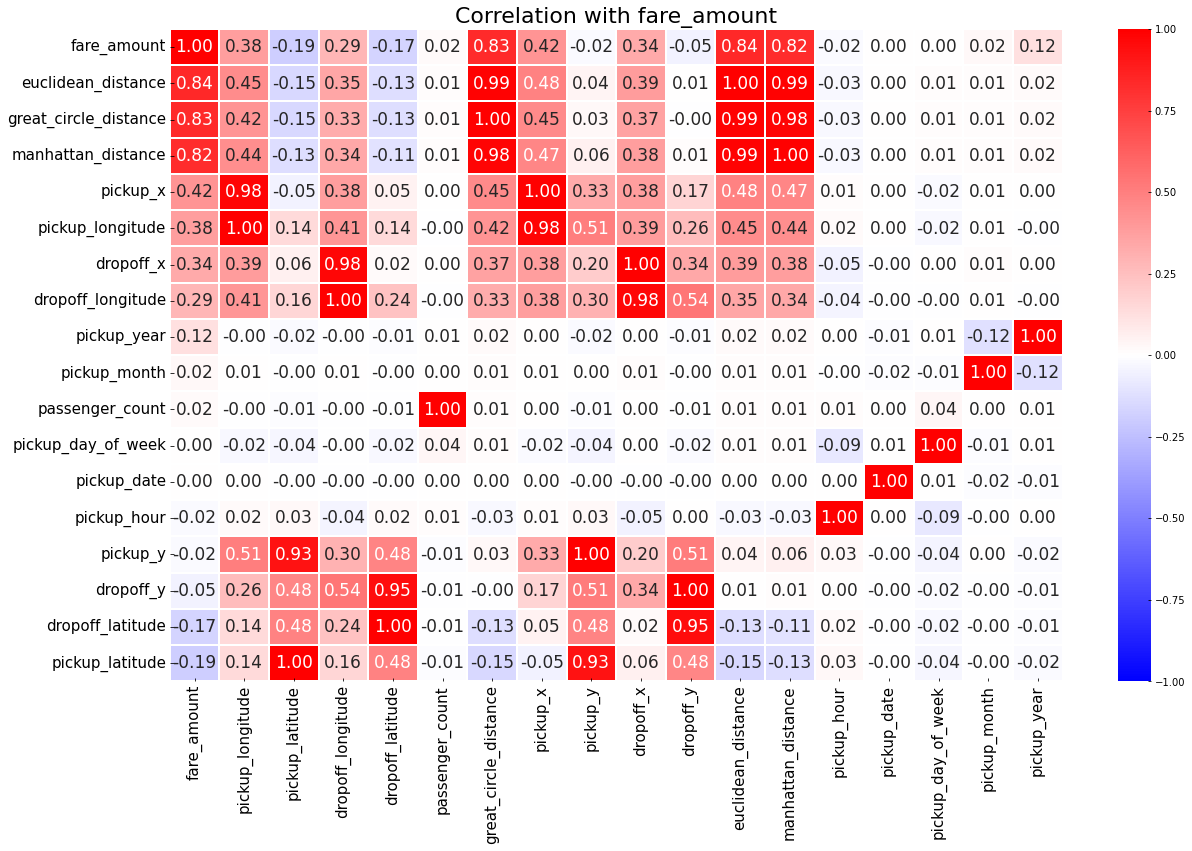

In [67]:
corr = train_df.corr().sort_values(by='fare_amount', ascending=False)
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(corr, annot = True, cmap ='bwr', ax = ax, fmt='.2f', linewidths = 0.05, annot_kws = {'size': 17}, vmin=-1, vmax=1)
ax.tick_params(labelsize = 15)
ax.set_title('Correlation with fare_amount', fontsize = 22)
plt.show()

## 5.2 Year over year trends

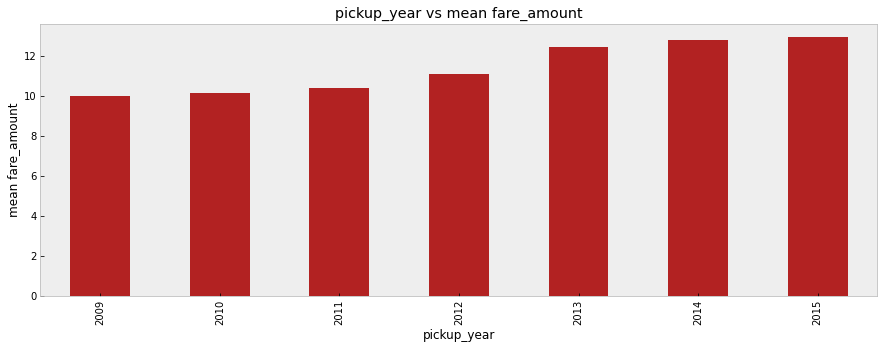

In [68]:
pivot_year = pd.pivot_table(train_df, values = 'fare_amount', index = 'pickup_year', aggfunc = ['mean'])

fig, ax = plt.subplots(figsize = (15,5))
pivot_year.plot(kind = 'bar', legend = False, color = 'firebrick', ax = ax)
ax.set(title = 'pickup_year vs mean fare_amount', ylabel= 'mean fare_amount')
plt.show()

## 5.3 Pickup location trends

In [69]:
print('x_range and y_range for pickup_locations:')
print(train_df.pickup_longitude.min(), train_df.pickup_longitude.max())
print(train_df.pickup_latitude.min(), train_df.pickup_latitude.max())

print('\nx_range and y_range for dropoff_locations:')
print(train_df.dropoff_longitude.min(), train_df.dropoff_longitude.max())
print(train_df.dropoff_latitude.min(), train_df.dropoff_latitude.max())

x_range and y_range for pickup_locations:
-74.932655 -72.50902
40.06092 41.922787

x_range and y_range for dropoff_locations:
-74.964264 -72.496155
40.05372 41.980816


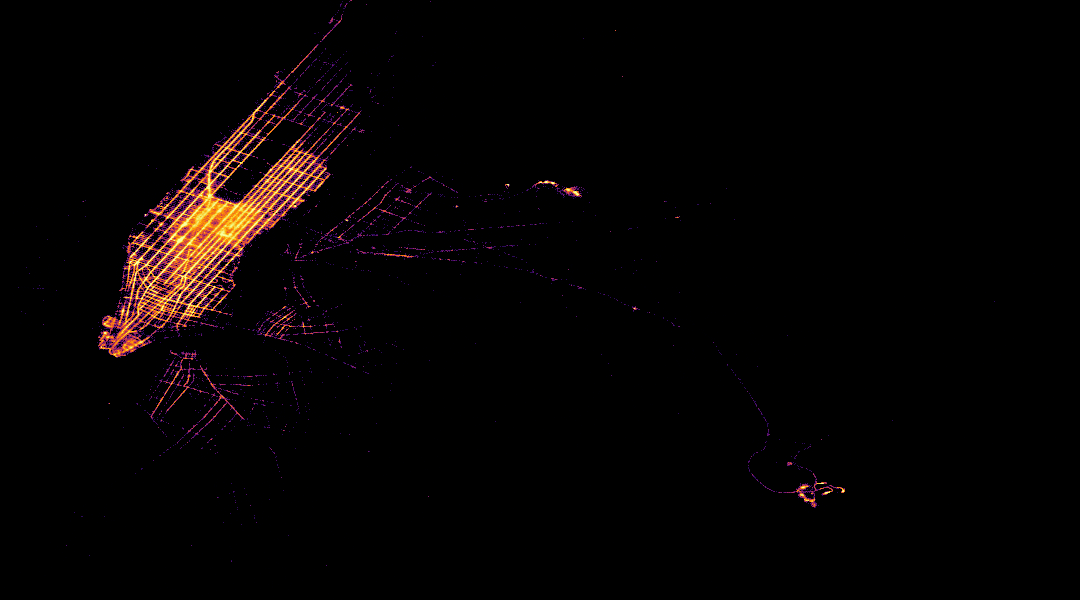

In [70]:
def plot_location(df, lon,lat, c_map):
    # Initial datashader visualization configuration
    x_range, y_range = ((-74.05, -73.7), (40.6, 40.85))
    # Initiate canvas and create grid
    cvs = ds.Canvas(plot_width = 1080, plot_height = 600, x_range = x_range, y_range = y_range)
    agg = cvs.points(df, lon, lat)
    # Create image map with custom color map
    img = tf.shade(agg, cmap = c_map, how = 'eq_hist')
    return tf.set_background(img, 'black')

plot_location(train_df, 'pickup_longitude', 'pickup_latitude', inferno)

## 5.4 Dropoff Location

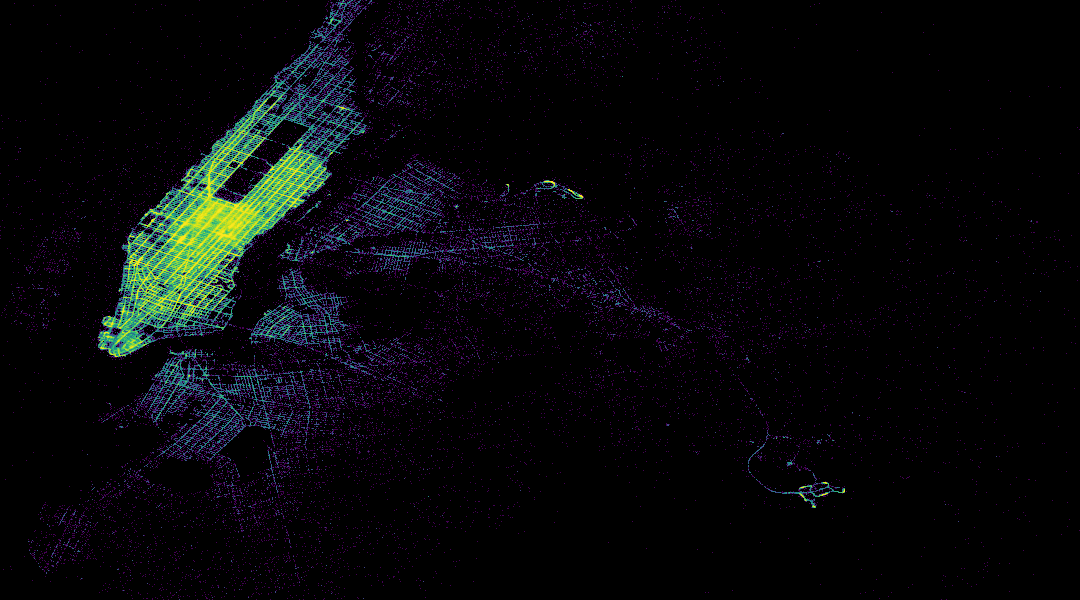

In [71]:
plot_location(train_df, 'dropoff_longitude', 'dropoff_latitude', viridis)

## 5.5 Morning Traffic

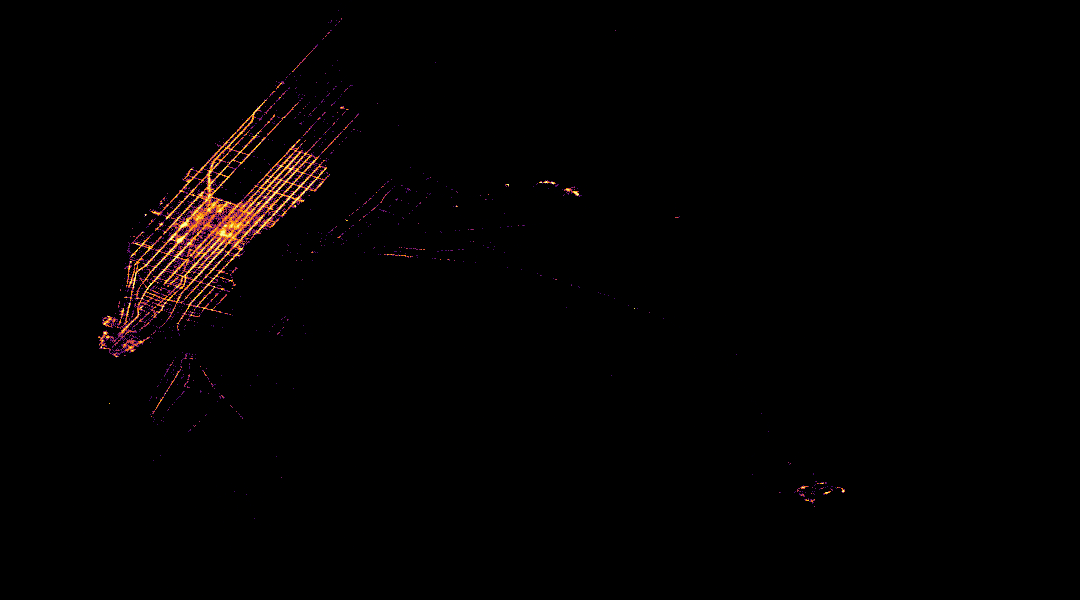

In [72]:

# Filter for morning hours (e.g., 7 AM to 11 AM)
morning_traffic = train_df[(train_df['pickup_hour'] >= 7) & (train_df['pickup_hour'] < 11)]
plot_location(morning_traffic, 'pickup_longitude', 'pickup_latitude', inferno)

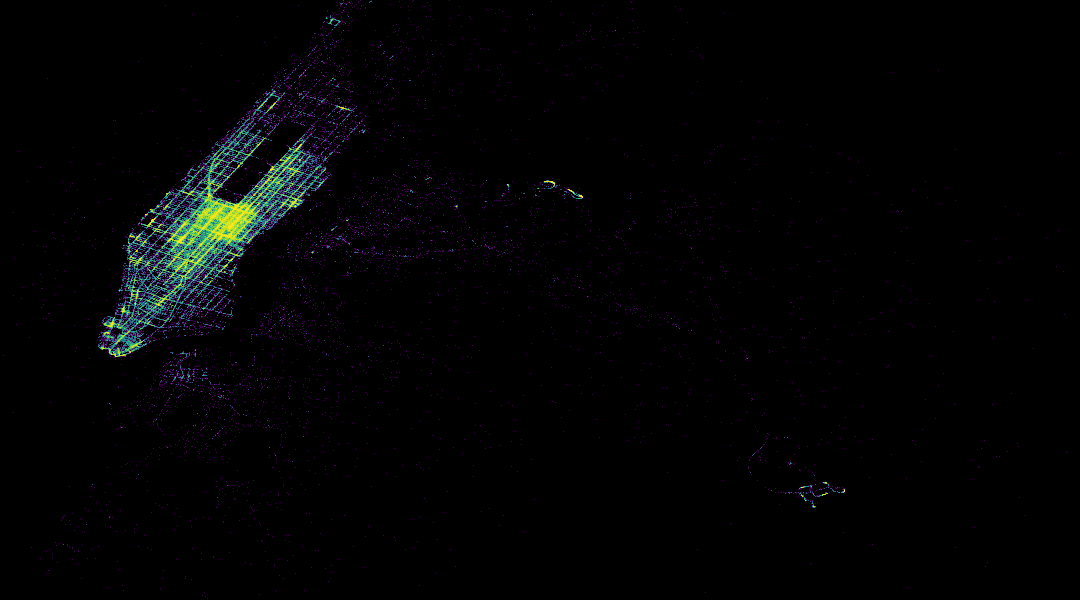

In [73]:
plot_location(morning_traffic, 'dropoff_longitude', 'dropoff_latitude', viridis)

## 5.6 Evening Traffic

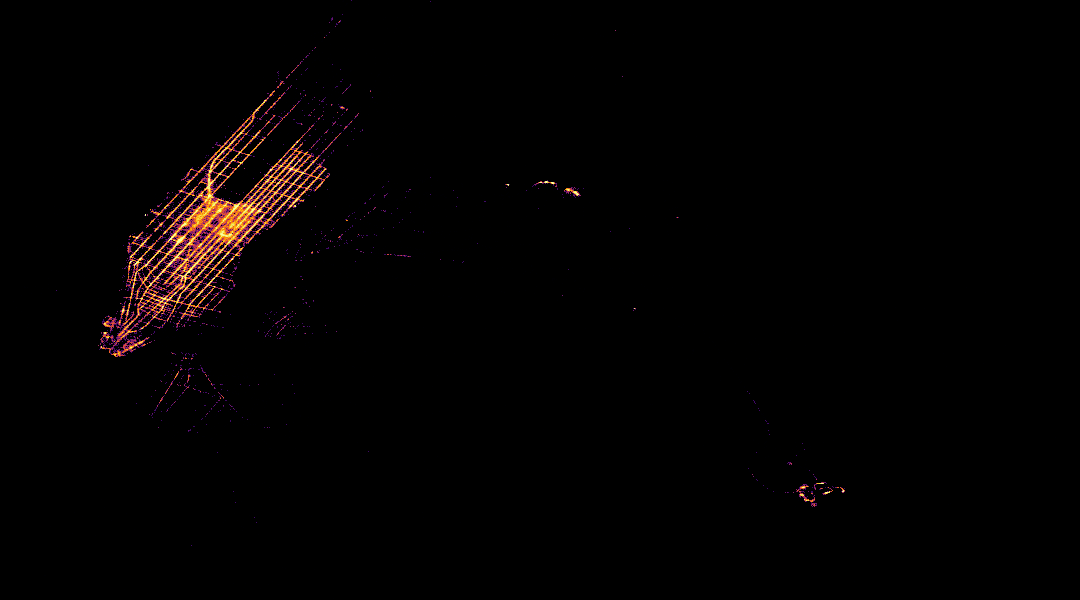

In [74]:
# Filter for evening hours (e.g., 4 PM to 8 PM)
evening_traffic = train_df[(train_df['pickup_hour'] >= 16) & (train_df['pickup_hour'] < 20)]
plot_location(evening_traffic, 'pickup_longitude', 'pickup_latitude', inferno)

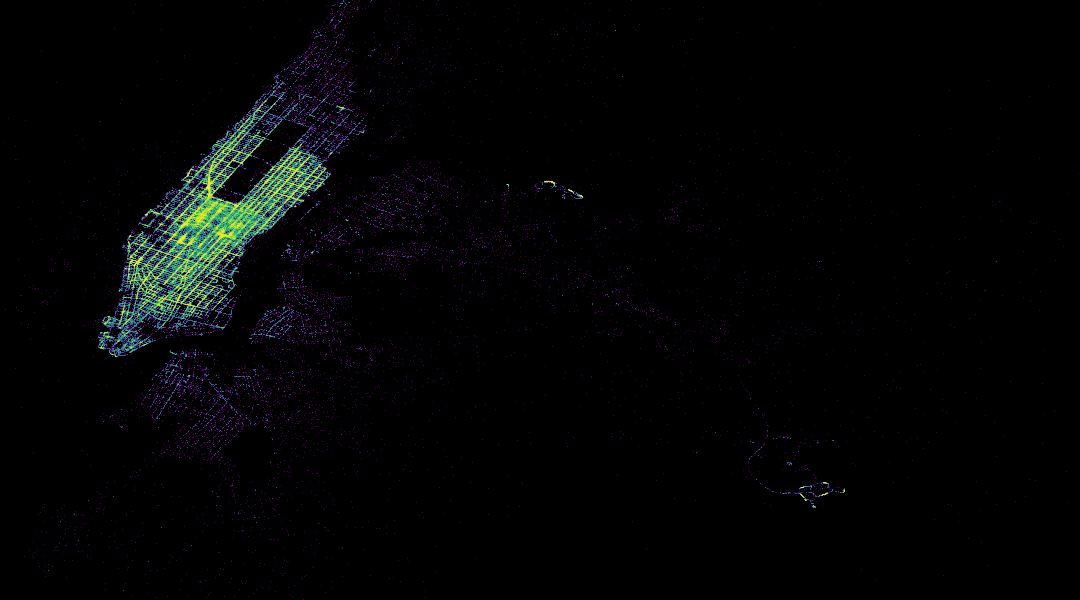

In [75]:
plot_location(evening_traffic, 'dropoff_longitude', 'dropoff_latitude', viridis)

## 5.7 Two in One

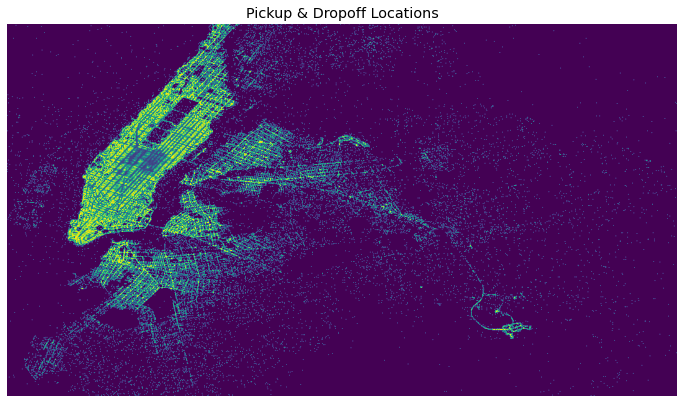

In [76]:
import matplotlib.pyplot as plt

pickup_img = plot_location(train_df, 'pickup_longitude', 'pickup_latitude', inferno)
dropoff_img = plot_location(train_df, 'dropoff_longitude', 'dropoff_latitude', viridis)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(pickup_img, alpha=1)  # Set transparency
ax.imshow(dropoff_img, alpha=1)
ax.set_title("Pickup & Dropoff Locations")
ax.axis('off')
ax.invert_yaxis()

plt.show()

# 6. Linear Regression - Prediction Model

In [77]:
y_train = train_df.fare_amount
X_train = train_df.drop(['fare_amount'], axis = 1)
y_test = test_df.fare_amount
X_test = test_df.drop(['fare_amount'], axis = 1)

In [78]:
y_test

0 30.9
1 33.3
2 6.5
3 6.0
4 5.5
 ... 
199995 14.1
199996 6.1
199997 5.3
199998 12.1
199999 7.0
Name: fare_amount, Length: 195784, dtype: float64

In [79]:
X_train.columns, y_train.name, X_test.columns, y_test.name

(Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'passenger_count', 'great_circle_distance',
        'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y', 'euclidean_distance',
        'manhattan_distance', 'pickup_hour', 'pickup_date',
        'pickup_day_of_week', 'pickup_month', 'pickup_year'],
       dtype='object'),
 'fare_amount',
 Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'passenger_count', 'great_circle_distance',
        'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y', 'euclidean_distance',
        'manhattan_distance', 'pickup_hour', 'pickup_date',
        'pickup_day_of_week', 'pickup_month', 'pickup_year'],
       dtype='object'),
 'fare_amount')

RMSE of linear regression model with all features: 4.64


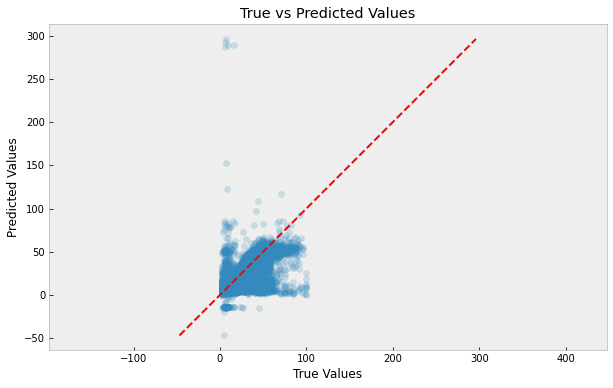

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

def train_and_predict(X_train, y_train, X_test, feat=None):
    if feat:
        X_train = X_train[feat]
        X_test = X_test[feat]

    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)

    y_pred = linear_reg.predict(X_test)

    return y_pred

# Experiment: Linear regression model with all features
y_pred = train_and_predict(X_train, y_train, X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print('RMSE of linear regression model with all features: \
{:0.2f}'.format(rmse))

# Plotting the predicted values against the true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Set the same boundaries for x and y axes
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Plot a 45-degree line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.axis('equal')  # Ensure aspect ratio is equal
plt.show()